<a href="https://colab.research.google.com/github/masoudmahdavi/Localization-emojies/blob/main/Emojis_localization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Import essential libraries

In [24]:
#Check Tensorflow version
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
2.14.0


In [25]:
import os
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from PIL import Image, ImageDraw
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

#1. Download Emojis from Github and Data preparation

In [26]:
Emojis_dir = os.path.join('Emojis')
if not os.path.exists("Emojis"):
    !wget https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip
    !mkdir {Emojis_dir}
    !unzip openmoji-72x72-color.zip -d {Emojis_dir}
    !rm openmoji-72x72-color.zip

In [27]:
Emojis_Dict = [{'name':'happy', 'file_name':'1F642.png'},
               {'name':'sad', 'file_name':'1F630.png'},
               {'name':'cool', 'file_name':'1F60E.png'},
              ]
Emojis_number = len(Emojis_Dict)

In [28]:
a = [i['file_name'] for i in Emojis_Dict]
for i in a:
  !mv {Emojis_dir}/{i} /content
!rm -rf {Emojis_dir}
!mkdir {Emojis_dir}

for i in a:
  !mv {i} {Emojis_dir}

In [29]:
#Convert Emojis dimntions from 4D to 3D
for i in Emojis_Dict:
    png_file = Image.open(os.path.join(Emojis_dir ,i['file_name'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask=png_file.split()[3])
    i['image'] = new_file

#2. Plot Emojis

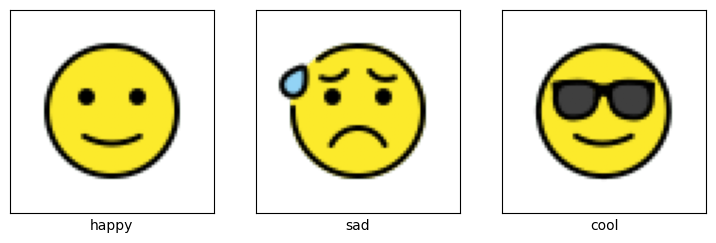

In [30]:
plt.figure(figsize=(9,9))
for i, d in enumerate(Emojis_Dict):
    _emojis_dir=os.path.join(Emojis_dir, d['file_name'])
    plt.subplot(3,3,i+1)
    plt.imshow(plt.imread(_emojis_dir))
    plt.xlabel(d['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

# 3. Generate emoji samples on a 200x200 page

In [31]:
def create_example():
    class_id = np.random.randint(0, Emojis_number)
    image = np.ones((200, 200, 3))*255
    image_np = np.array(image)
    row = np.random.randint(0, 128)
    col = np.random.randint(0, 128)
    image_np[row:row+72, col:col+72, :] = np.array(Emojis_Dict[class_id]['image'])
    #return image_np.astype('uint8'), class_id, (row+10)/200, (col+10)/200
    return image_np.astype('uint8'), class_id, row+10, col+10


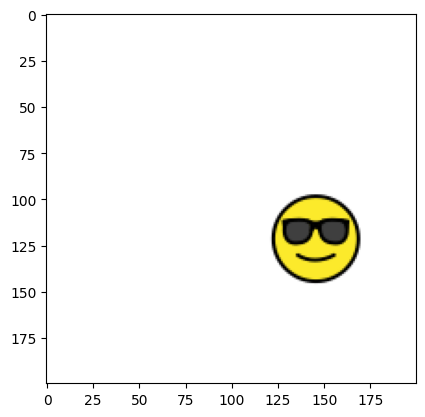

In [32]:
image, class_id, row, col= create_example()
plt.imshow(image)

#4. Plot the bounary box of Emojis

In [33]:
def plot_Bounding_Box(image, ground_truth_bbx, predicted_bbx=[], norm=False):
    if norm:
        image *= 255.
        image = image.astype('uint8')
    gt_row, gt_col = ground_truth_bbx
    #gt_row, gt_col = gt_row * 200, gt_col * 200
    image_PIL = Image.fromarray(image.astype(np.uint8))
    draw = ImageDraw.Draw(image_PIL)
    draw.rectangle(xy = (gt_col, gt_row, gt_col+52, gt_row+52),
               outline = 'green',
               width = 3)

    if len(predicted_bbx) == 2:
        try:
            pr_row, pr_col = predicted_bbx
            #pr_row, pr_col = pr_row * 200, pr_col * 200
            draw.rectangle(xy = (pr_col, pr_row, pr_col+52, pr_row+52),
               outline = 'red',
               width = 3)
        except:
            print('Enter the correct row and column value')
    return image_PIL

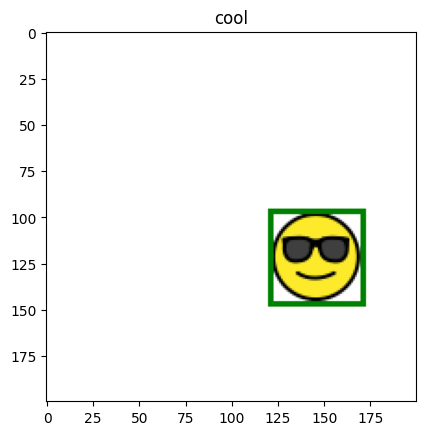

In [34]:
image = plot_Bounding_Box(image, [row, col])
plt.title(Emojis_Dict[class_id]['name'])
plt.imshow(image)
plt.show()

#5. Generate Emojis data

In [35]:
def data_generator(batch_size=16):
    while True:
        x_batch = np.zeros((batch_size, 200, 200, 3))
        y_batch = np.zeros((batch_size, Emojis_number))
        bbox_batch = np.zeros((batch_size, 2))

        for i in range(0, batch_size):
            image, class_id, row, col= create_example()
            x_batch[i] = image
            #x_batch[i] = image / 255.
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}

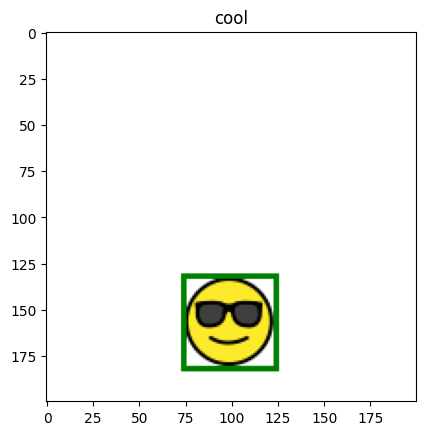

In [36]:
example, label = next(data_generator(1))
image = example['image'][0]
target = np.argmax(label['class_out'][0])
row, col = label['box_out'][0]
image = plot_Bounding_Box(image, [row, col])
plt.imshow(image)
plt.title(Emojis_Dict[target]['name'])
plt.show()

#6. Build VGG16 Model

In [37]:

input_ = Input(shape=(200, 200, 3), name='image')

x = input_

for i in range(0, 5):
  n_filters = 2**(4 + i)
  x = Conv2D(n_filters, 3, activation='relu')(x)
  x = BatchNormalization()(x)
  x = MaxPool2D(2)(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)

class_out = Dense(3, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input_, [class_out, box_out])
model.summary()

"""
input = Input(shape=(200, 200, 3), name='image')

x = input

x = Conv2D(filters=64, kernel_size=(3,3) ,padding="same", activation="relu")(x)
x = Conv2D(filters=64, kernel_size=(3,3) ,padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)
x = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)

x = Flatten()(x)
x = Dense(units=4096,activation="relu")(x)
x = Dense(units=4096,activation="relu")(x)

class_out = Dense(Emojis_number, activation='softmax', name='class_out')(x)
box_out = Dense(2, name='box_out')(x)

model = tf.keras.models.Model(input, [class_out, box_out])
"""

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 198, 198, 16)         448       ['image[0][0]']               
                                                                                                  
 batch_normalization_5 (Bat  (None, 198, 198, 16)         64        ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 99, 99, 16)           0         ['batch_normalization_5[

'\ninput = Input(shape=(200, 200, 3), name=\'image\')\n\nx = input\n\nx = Conv2D(filters=64, kernel_size=(3,3) ,padding="same", activation="relu")(x)\nx = Conv2D(filters=64, kernel_size=(3,3) ,padding="same", activation="relu")(x)\nx = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)\nx = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)\nx = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = MaxPool2D(pool_size=(2,2),strides=(2,2))(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu")(x)\nx = Conv2D(filters=512, kernel_size=(3,3), padd

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image (InputLayer)          [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 conv2d_5 (Conv2D)           (None, 198, 198, 16)         448       ['image[0][0]']               
                                                                                                  
 batch_normalization_5 (Bat  (None, 198, 198, 16)         64        ['conv2d_5[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 max_pooling2d_5 (MaxPoolin  (None, 99, 99, 16)           0         ['batch_normalization_5[

#7. Custom metric: IOU

In [39]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight = None):
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 200, cols * 200
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            return x1, y1, x2, y2

        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        pr_x1, pr_y1, pr_x2, pr_y2 = get_box(y_pred)

        i_x1 = tf.maximum(gt_x1, pr_x1)
        i_x2 = tf.maximum(gt_x2, pr_x2)
        i_y1 = tf.maximum(gt_y1, pr_y1)
        i_y2 = tf.maximum(gt_y2, pr_y2)

        def get_area(x1, x2, y1, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)

        i_area = get_area(i_x1, i_x2, i_y1, i_y2)
        u_area = get_area(gt_x1, gt_x2, gt_y1, gt_y2) + get_area(pr_x1, pr_x2, pr_y1, pr_y2) - i_area

        iou = tf.math.divide(i_area, u_area)

        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)

    def result(self):
        return self.iou

    def reset_status(self):
        self.iou = self.add_weight(name='iou', initializer='zeros')
        self.total_iou = self.add_weight(name='total_iou', initializer='zeros')
        self.num_ex = self.add_weight(name='num_ex', initializer='zeros')


#8. Compile model

In [40]:
model.compile(
    loss={
        'class_out':'categorical_crossentropy',
        'box_out':'mse'
    },
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics={
        'class_out':'accuracy',
        'box_out':IoU(name='iou')
    }
)

#9. Testing the untrained model

In [44]:
def test_model(model, test_datagen):
    example, label= next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)
    class_pred = np.argmax(pred_y[0])
    pred_coords = pred_box[0]
    true_coords = box[0]
    image = x[0]

    gt = Emojis_Dict[np.argmax(y[0])]['name']
    predict_emojis_name = Emojis_Dict[class_pred]['name']

    image = plot_Bounding_Box(image, true_coords, pred_coords)
    color = 'green' if gt == predict_emojis_name else 'red'

    plt.imshow(image)
    plt.xlabel('Predicted {}'.format(predict_emojis_name), color=color)
    plt.ylabel('Ground truth {}'.format(gt), color=color)
    plt.xticks([])
    plt.yticks([])

In [45]:
def test(model):
    test_datagen = data_generator(1)
    plt.figure(figsize=(16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i+1)
        test_model(model, test_datagen)
    plt.show()

1/1 [==============================] - 0s 18ms/step


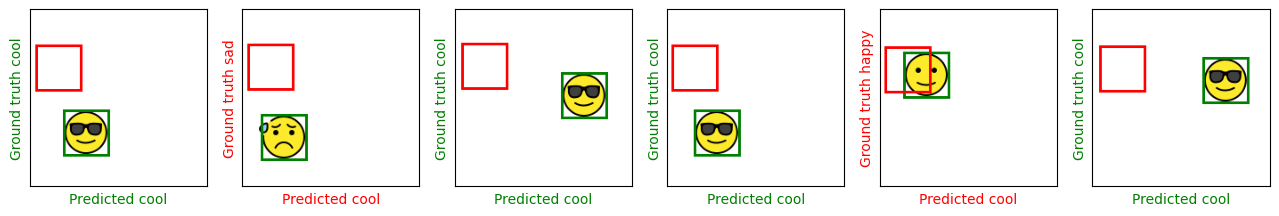

In [46]:
test(model)

#10. Custom callback

In [47]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

#11. Model Training

Epoch 1/40
1/1 [==============================] - 0s 18ms/step


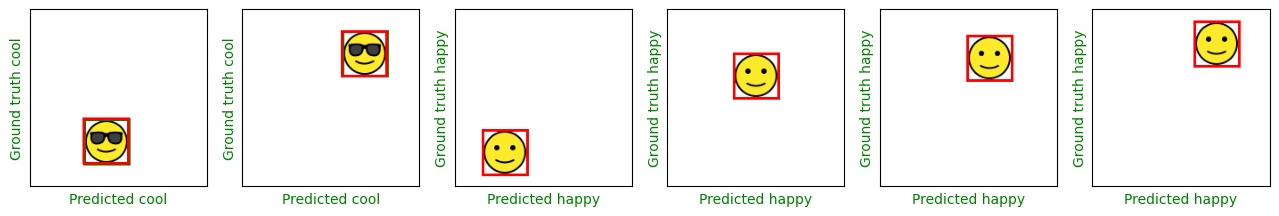

500/500 [==============================] - 14s 29ms/step - loss: 0.2742 - class_out_loss: 0.0012 - box_out_loss: 0.2730 - class_out_accuracy: 1.0000 - box_out_iou: 1.0000 - lr: 2.0000e-04
Epoch 2/40
1/1 [==============================] - 0s 19ms/step


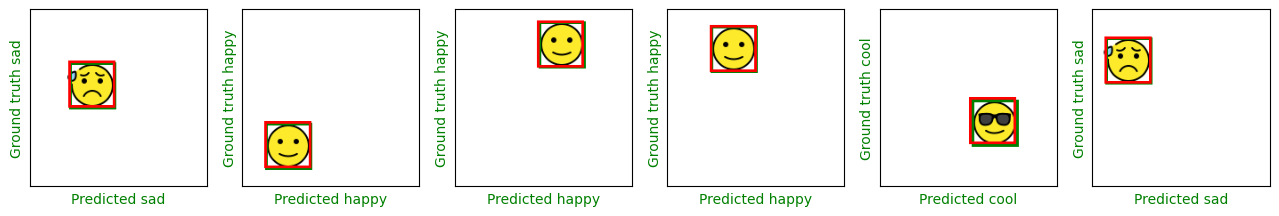

500/500 [==============================] - 15s 30ms/step - loss: 0.2673 - class_out_loss: 0.0015 - box_out_loss: 0.2658 - class_out_accuracy: 0.9994 - box_out_iou: 1.0000 - lr: 2.0000e-04
Epoch 3/40
1/1 [==============================] - 0s 19ms/step


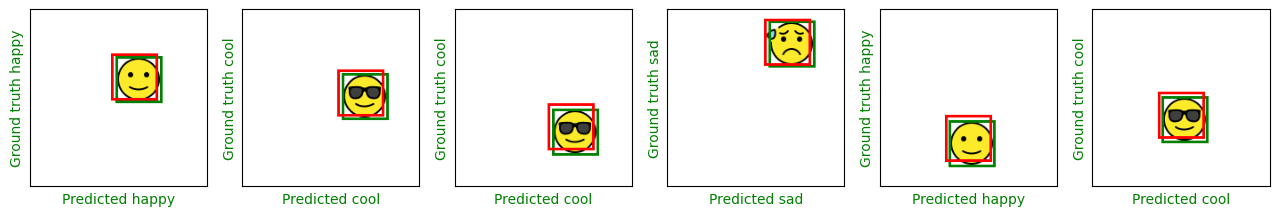

500/500 [==============================] - 14s 29ms/step - loss: 0.3169 - class_out_loss: 0.0016 - box_out_loss: 0.3154 - class_out_accuracy: 0.9994 - box_out_iou: 1.0000 - lr: 2.0000e-04
Epoch 4/40
1/1 [==============================] - 0s 19ms/step


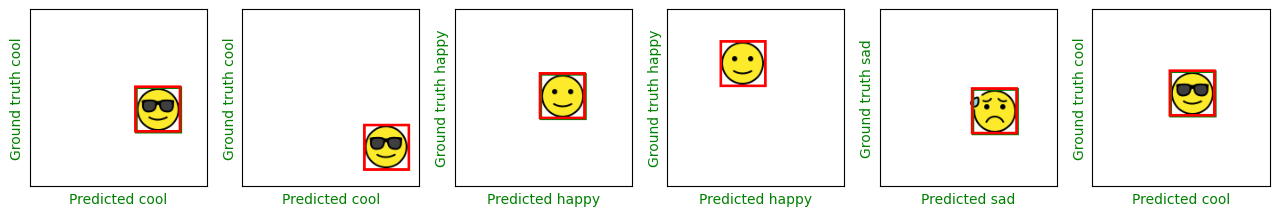

500/500 [==============================] - 15s 29ms/step - loss: 0.3266 - class_out_loss: 0.0031 - box_out_loss: 0.3235 - class_out_accuracy: 0.9992 - box_out_iou: 1.0000 - lr: 2.0000e-04
Epoch 5/40
1/1 [==============================] - 0s 21ms/step


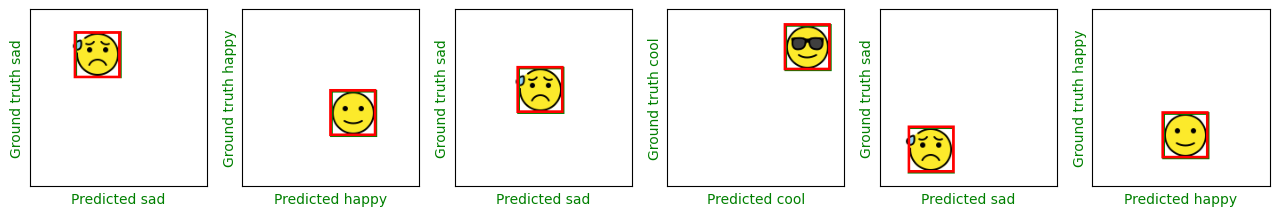

500/500 [==============================] - 15s 30ms/step - loss: 0.1191 - class_out_loss: 2.7861e-04 - box_out_loss: 0.1188 - class_out_accuracy: 1.0000 - box_out_iou: 1.0000 - lr: 4.0000e-05
Epoch 6/40
1/1 [==============================] - 0s 18ms/step


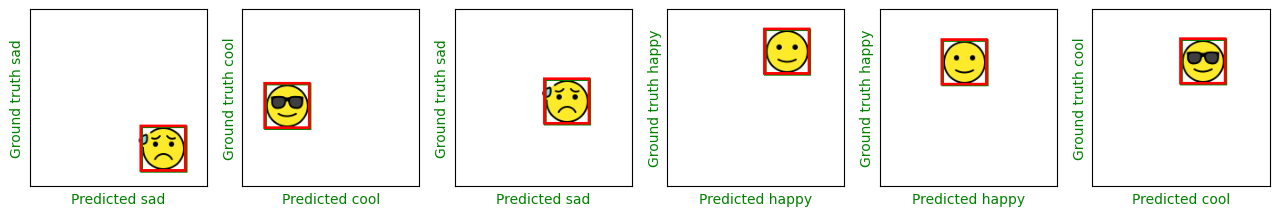

500/500 [==============================] - 15s 29ms/step - loss: 0.1045 - class_out_loss: 1.6006e-04 - box_out_loss: 0.1043 - class_out_accuracy: 1.0000 - box_out_iou: 1.0000 - lr: 4.0000e-05
Epoch 7/40
1/1 [==============================] - 0s 21ms/step


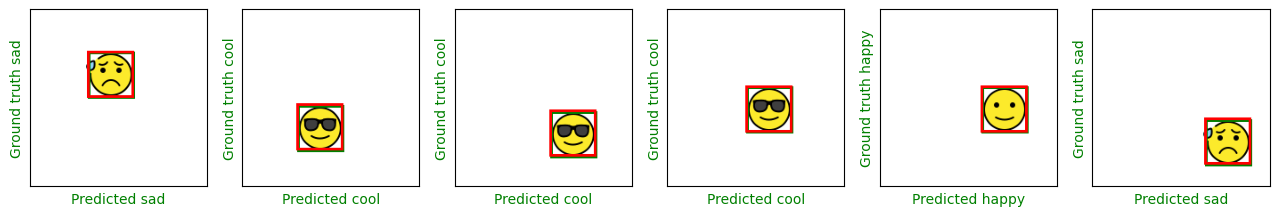

500/500 [==============================] - 15s 29ms/step - loss: 0.1182 - class_out_loss: 2.6024e-04 - box_out_loss: 0.1180 - class_out_accuracy: 1.0000 - box_out_iou: 1.0000 - lr: 4.0000e-05


In [52]:
def lr_sch(epoch, lr):
    if (epoch+1) % 5 == 0:
        lr *= 0.2
    return max(lr, 3e-7)

model.fit(data_generator(),
         epochs=40,
         steps_per_epoch=500,
         callbacks=[
             ShowTestImages(),
             tf.keras.callbacks.EarlyStopping(monitor='box_out_iou', patience=6, mode='max'),
             tf.keras.callbacks.LearningRateScheduler(lr_sch)
         ]
         )

1/1 [==============================] - 0s 23ms/step


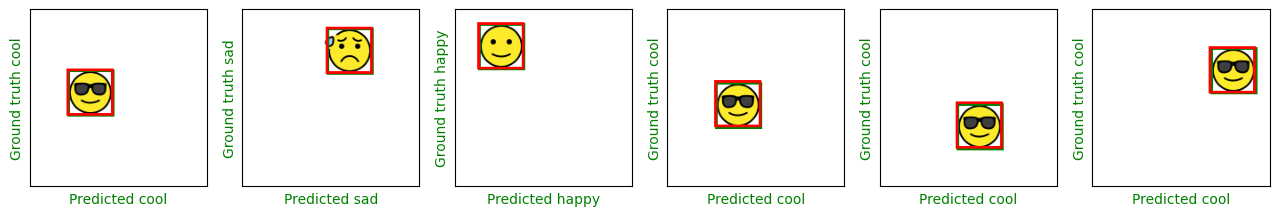

In [53]:
test(model)